# Test Shubert 2D
---
Description:

- Optimization (min)
- Multimodal (yes)
---
The Shubert function has several local minima and many global minima. The equation is given by:

$f\left(x, y\right) = \left(\sum_{i=1}^5 i* \cos((i+1)*x + i)\right) \left(\sum_{i=1}^5 i* \cos((i+1)*y + i)\right)$

The function is usually evaluated on the square $x, y \in [-10, 10]$, although this may be restricted
to the square $x, y \in [-5.12, 5.12]$.

Global minimum:
$f^*(x_{opt}, y_{opt}) = -186.7309$

## First we import python libraries and set up the directory

In [1]:
import os, sys
import numpy as np
from numba import njit
from scipy.stats import qmc
from collections import defaultdict
from matplotlib import pyplot as plt

# Enable LaTex in plotting.
plt.rcParams["text.usetex"] = True

PROJECT_DIR = os.path.abspath("..")
sys.path.append(PROJECT_DIR)

## Here we import all our custom PSO code

In [2]:
from star_pso.population.swarm import Swarm
from star_pso.population.particle import Particle
from star_pso.engines.standard_pso import StandardPSO
from star_pso.utils.auxiliary import cost_function

In [3]:
def count_particles_per_mode(x_pos: np.ndarray, modes: list,
                             radius: int = 1.0) -> dict:
    cppm = defaultdict(int)

    for px, py in x_pos:
        for vals in modes:
            cx, cy = vals
            if (px - cx)**2 + (py - cy)**2 <= radius**2:            
                cppm[tuple(vals)] += 1
                break
            # _end_if_
    # _end_for_
    return cppm
# _end_def_

## Define the multi-modal function

$f\left(x, y\right) = \left(\sum_{i=1}^5 i* \cos((i+1)*x + i)\right) \left(\sum_{i=1}^5 i* \cos((i+1)*y + i)\right)$

In [4]:
@njit(fastmath=True)
def fun_shubert_vectorized(x: np.ndarray, y: np.ndarray) -> np.ndarray:
    # Define the range [1, 2, 3, 4, 5].
    i = np.arange(1, 6)

    # Calculate the first summation over each x.
    sum_x = np.sum(i[:, np.newaxis] * np.cos((i[:, np.newaxis] + 1) * x + i[:, np.newaxis]), axis=0)

    # Calculate the second summation over each y.
    sum_y = np.sum(i[:, np.newaxis] * np.cos((i[:, np.newaxis] + 1) * y + i[:, np.newaxis]), axis=0)

    # Return the product of both sums.
    return sum_x * sum_y

In [5]:
@cost_function(minimize=True)
def fun_test2D(x_array: np.ndarray, **kwargs) -> float:

    # Extract the values.
    x, y = x_array
    
    # Compute the final value.
    f_xy = fun_shubert_vectorized(x, y)
    
    # Return the solution.
    return f_xy.item()
# _end_def_

## Here we set the PSO parameters

- Set the number of particles 'N'
- Setup the initial population
- Create the PSO object

In [6]:
# Random number generator.
rng = np.random.default_rng()

# Define the size of the problem (number of particles, dimensions).
n_pop, n_dim = 400, 2

# Set the bounds.
l_bounds = [-10.0, -10.0]
u_bounds = [+10.0, +10.0]

# Define the sampling method.
sample_method = "RANDOM"

if sample_method == "RANDOM":
    # Draw random samples for the initial points.
    Xt0 = rng.uniform(-10.0, +10.0, size=(n_pop, n_dim))
else:
    # Draw samples using Latin Hyper Cube approach.
    sampler = qmc.LatinHypercube(n_dim, rng=rng, optimization="random-cd")

    # Sample initial positions.
    Xt0 = sampler.random(n_pop)
    
    # Scale the positions.
    Xt0 = qmc.scale(Xt0, l_bounds, u_bounds)
# _end_if_

# Initial population.
swarm_t0 = Swarm([Particle(x) for x in Xt0])

# Create the StandardPSO object that will carry on the optimization.
test_PSO = StandardPSO(initial_swarm = swarm_t0, obj_func = fun_test2D,
                       x_min = l_bounds, x_max = u_bounds)

## Optimization process

In [7]:
test_PSO.run(max_it = 500,
             options = {"w0": 0.70, "c1": 1.50, "c2": 1.50, "mode": "multimodal"},
             reset_swarm = False, verbose = True, adapt_params = False)

11/29/2025 21:31:52 INFO: Initial f_optimal = 167.1967
11/29/2025 21:31:57 INFO: Iteration:     1 -> f_optimal = 114.5246
11/29/2025 21:31:58 INFO: Iteration:    51 -> f_optimal = 186.7307
11/29/2025 21:31:59 INFO: Iteration:   101 -> f_optimal = 186.7309
11/29/2025 21:31:59 INFO: Iteration:   151 -> f_optimal = 186.7309
11/29/2025 21:32:00 INFO: Iteration:   201 -> f_optimal = 186.7309
11/29/2025 21:32:01 INFO: Iteration:   251 -> f_optimal = 186.7309
11/29/2025 21:32:01 INFO: Iteration:   301 -> f_optimal = 186.7309
11/29/2025 21:32:02 INFO: Iteration:   351 -> f_optimal = 186.7309
11/29/2025 21:32:03 INFO: Iteration:   401 -> f_optimal = 186.7309
11/29/2025 21:32:03 INFO: Iteration:   451 -> f_optimal = 186.7309


Final f_optimal = 186.7309
run: elapsed time = 14.140 seconds.


In [8]:
# Get the optimal solution from the PSO.
_, f_opt, x_opt = test_PSO.get_optimal_values()

# Print the resutls.
print(f"x={x_opt}, f(x) = {-f_opt:.5f}")

x=[4.85805688 5.48286421], f(x) = -186.73091


In [9]:
best_n = []

for p in test_PSO.swarm.best_n(n=n_pop):
    best_n.append(p.position)
    
best_n = np.unique(np.array(best_n), axis=0)

In [10]:
# Prepare a list with all the global optima.
global_optima =[(-7.0835, -7.7083),
                (-7.0835, -1.4250),
                (-7.0835, +4.8601),
                
                (-0.8003, -7.7083),
                (-0.8003, -1.4250),
                (-0.8003, +4.8601),
                
                (+5.4858, -7.7083),
                (+5.4858, -1.4250),
                (+5.4858, +4.8601),
                
                (-7.7083, -7.0835),
                (-7.7083, -0.8003),
                (-7.7083, +5.4858),
                
                (-1.4250, -7.0835),
                (-1.4250, -0.8003),
                (-1.4250, +5.4858),
                
                (+4.8601, -7.0835),
                (+4.8601, -0.8003),
                (+4.8601, +5.4858)]

optima = np.array(global_optima)

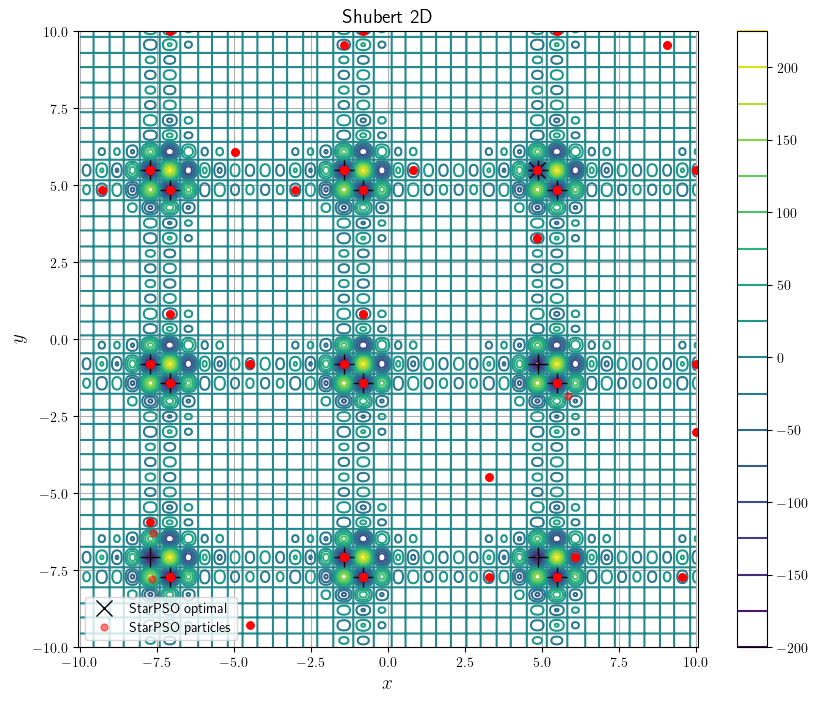

In [11]:
# Prepare the plot of the real density.
x, y = np.mgrid[-10.0:10.01:0.01, -10.0:10.01:0.01]

plt.subplots(figsize=(10, 8))

# First plot the contour of the "true" function.
plt.contour(x, y, np.reshape(fun_shubert_vectorized(x.flatten(),
                                                    y.flatten()),
                             shape=(x.shape[0], y.shape[0])),
            levels=15)

# Plot the global optima.
plt.plot(optima[:, 0], optima[:, 1], "k+", markersize=14)

# Plot the optimal PSO.
plt.plot(x_opt[0], x_opt[1], "kx", markersize=12, label="StarPSO optimal")

# Plot the best_n.
plt.plot(best_n[:, 0], best_n[:, 1], "ro", alpha=0.5, markersize=5, label="StarPSO particles")

# Add labels.
plt.xlabel("$x$", fontsize=14)
plt.ylabel("$y$", fontsize=14)
plt.title("Shubert 2D", fontsize=14)
plt.legend()

# Final setup.
plt.colorbar()
plt.axis("equal")
plt.grid()

# Save to file.
plt.savefig("Shubert_2D.pdf", format="pdf", dpi=300)

In [12]:
counts = count_particles_per_mode(best_n, global_optima, radius=0.15)

for i, vals in enumerate(counts.items(), start=1):
    optimum, n_particles = vals
    print(f"{i:>3}, optimum: ({optimum[0]:>+7.4f}, {optimum[1]:>+7.4f}), n-particles: {n_particles:>3}")

  1, optimum: (-7.7083, +5.4858), n-particles:  16
  2, optimum: (-7.7083, -0.8003), n-particles:  13
  3, optimum: (-7.0835, +4.8601), n-particles:  12
  4, optimum: (-7.0835, -7.7083), n-particles:  21
  5, optimum: (-7.0835, -1.4250), n-particles:  14
  6, optimum: (-1.4250, +5.4858), n-particles:  25
  7, optimum: (-1.4250, -7.0835), n-particles:  22
  8, optimum: (-1.4250, -0.8003), n-particles:   8
  9, optimum: (-0.8003, -7.7083), n-particles:  13
 10, optimum: (-0.8003, -1.4250), n-particles:  11
 11, optimum: (-0.8003, +4.8601), n-particles:  10
 12, optimum: (+4.8601, +5.4858), n-particles:  12
 13, optimum: (+5.4858, -7.7083), n-particles:  17
 14, optimum: (+5.4858, -1.4250), n-particles:  25
 15, optimum: (+5.4858, +4.8601), n-particles:   6


### End of file